## Customer Preference Analysis

The task is to analyze user comments in the 'Entry Level Luxury Sedan' forum on Edmunds and provide insights to brand managers. <br>

Let's load the libraries we need for this analysis.

In [1]:
from selenium import webdriver

import time

import pandas as pd
import numpy as np
import openpyxl

import re
from string import punctuation

import nltk
from nltk.tokenize import word_tokenize

from nltk.corpus import stopwords

from nltk.stem import WordNetLemmatizer
lmtzr = WordNetLemmatizer()

In [2]:
# Try to read in the messages. If not present we run the scraper again!
try:
    df = pd.read_csv('Extracted_Messages.csv')
    df.head()
except:
    print("Extracted Messages not found. Scrape Again!")

In [3]:
df.head()

,Date,User_Id,Message
0,"September 7, 2018",dino001,If they keep it around in next four-five years...
1,"September 7, 2018",circlew,The lease rate is the factor that stops me col...
2,"September 8, 2018",qbrozen,"Yes, the completely noncomparable M2 would bea..."
3,"September 9, 2018",FlightNurse2,Why not a Genesis G70 with a manual?
4,"September 9, 2018",FlightNurse2,Are you talking about Genesis Dealers or Hyund...


### Task 1 - Visit the forums page
Approach - 
1. Edmunds.com has an 'Automobile Forums' section which is what we want to visit.
2. Clicking on that brings us to a page to select our required forum page using a search criteria - We want 'General' as Topic and 'Sedans' as the subtopic.
3. Executing the search brings us to a page with a list of forum pages with a variety of discussions.
4. We find the page with discussions about 'Entry Level Luxury Performance Sedans'

In [ ]:
# provide location to chromedriver and open chrome
chrome_path = r'C:/Users/sagar/Desktop/chromedriver'
driver = webdriver.Chrome(chrome_path)

# open the edmunds website
driver.get("https://www.edmunds.com")
time.sleep(2)

# scroll to the bottom of the page
driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

# go to the forums page
driver.find_element_by_link_text("""Automobile Forums""").click()
#driver.find_element_by_xpath("""/html/body/div[1]/div/div[13]/div/div[1]/div[3]/ul/li[8]/a""").click()

# select topics --> general
driver.find_element_by_xpath("""//*[@id="TopicSearch"]/option[14]""").click()

# when my browser hits the 'General' option, it takes a few seconds for the subtopic to get activated.
# i need to pause my code for some time before I search subtopic
time.sleep(5)

# select Subtopic --> sedans
driver.find_element_by_xpath("""//*[@id="SubtopicSearch"]/option[5]""").click()

# Execute the search for the Sedans forum
driver.find_element_by_xpath("""//*[@id="Form_Go_Topics"]""").click()

# find the entry level luxury performance sedans forum
driver.find_element_by_link_text("""Entry Level Luxury Performance Sedans""").click()

### Task 2 - Extract 6000 forum comments
1. Now that we are on the forums page, we need to extract 6000 comments.
2. The initial pages only return items that are very old. We need to extract things starting from the last page.
3. The format for extraction has to be -

| Date | User_Id | Message |
|------|---------|---------|

4. Write these out to a csv file.

In [ ]:
# get to the last page - There is no jump to last page button! We will have to do it one by one!
driver.find_element_by_xpath("""//*[@id="PagerBefore"]/a[8]""").click()

In [ ]:
# Extract all comments, quotes, dates and usernames on the page
messages = driver.find_elements_by_class_name("""Message""")
authors = driver.find_elements_by_class_name("""Username""")
dates = driver.find_elements_by_tag_name("""time""")
quote_text = driver.find_elements_by_class_name("""QuoteText""")

message_list = []
author_list = []
date_list = []
quote_text_list = []

# append each extracted element to a list
for message in messages:
    message_list.append(message.text)
    
for author in authors:
    author_list.append(author.text)

for date in dates:
    date_list.append(re.findall("(.*\s[0-9]+)\s",date.get_attribute("title"))[0])

for quote in quote_text:
    quote_text_list.append(quote.text)

    
# Till the length of the message list doesnt become 6000, keep going to the next page and extracting elements
while len(message_list) <= 6000:
    # This is the x_path for the next page
    driver.find_element_by_class_name("""Previous""").click()
    time.sleep(0.2)
    messages = driver.find_elements_by_class_name("""Message""")
    authors = driver.find_elements_by_class_name("""Username""")
    dates = driver.find_elements_by_tag_name("""time""")
    quote_text = driver.find_elements_by_class_name("""QuoteText""")
    
    for message in messages:
        message_list.append(message.text)
        
    for author in authors:
        author_list.append(author.text)

    for date in dates:
        date_list.append(re.findall("(.*\s[0-9]+)\s",date.get_attribute("title"))[0])
    
    for quote in quote_text:
        quote_text_list.append(quote.text)

If a comment is written in response to another, the original comment is still present in the response. We need to remove that.

In [ ]:
# Remove user quotes from the comments
for j in range(0,len(quote_text_list)):
    for i in range(0,len(message_list)):
        if (quote_text_list[j] in message_list[i]):
            message_list[i]=message_list[i].replace(quote_text_list[j],'')  
            
# Clean the message by removing newline characters
cleaned_messages = []
for message in message_list:
    cleaned_messages.append(re.sub("\n", " ", message))
    
# remove the said part as that is a comment
def extract_after_said(s):
    if len(re.findall(".*?\ssaid:(.*)", s)) > 0:
        s = re.findall(".*?\ssaid:(.*)", s)[0]
        return s
    else:
        return s

cleaned_message_final = []
for message in cleaned_messages:
    cleaned_message_final.append(extract_after_said(message)) 

Write this to a csv file to be used later since scraping takes time.

In [ ]:
# Put the messages, authors and dates in a dataframe
df = pd.DataFrame({'Date': date_list,
                  'User_Id': author_list,
                  'Message': cleaned_message_final})

# clean the messages
def clean_string(s):
    '''removes leading and trailing whitespaces'''
    s = s.rstrip().lstrip()
    s = re.sub(' +', ' ', s)
    return s

df['Message'] = df['Message'].map(clean_string)

# Drop if any row has a missing value
mask = df['Message'] != ""
df = df.loc[mask,].reset_index(drop = True)

# write this dataframe to a csv file
df.to_csv('Extracted_Messages.csv', index = False)

### Corpus cleaning
**Step 1:** *Convert all user comments to lower case*

In [ ]:
df2 = df.copy()

# convert to lower
df2['Message'] = df2['Message'].map(lambda x: x.lower())

def clean_string(s):
    '''removes leading and trailing whitespaces'''
    s = s.rstrip().lstrip()
    s = re.sub(' +', ' ', s)
    return s

df2['Message'] = df2['Message'].map(clean_string)

**Step 2:** *Read in the model-brand_name mapping.*

In [8]:
# read in the file with the model and brand mapping.
model_brand = pd.read_excel('models.xlsx')
model_brand['Brand'] = model_brand['Brand'].astype('object')
model_brand['Model'] = model_brand['Model'].astype('object')

# convert to lower case and strip whitespace
#model_brand['Model'] = model_brand['Model'].map(lambda x: x.rstrip().lower())
#model_brand['Brand'] = model_brand['Brand'].map(lambda x: x.rstrip().lower())

# remove duplicate rows if any
model_brand = model_brand.drop_duplicates().reset_index(drop = True)

**Step 3:** *Replace model names with brand names*

In [ ]:
# create a function that replaces each mention of a model name by its brand name
def replace_model_by_brand(s):
    '''Given a string, this replaces the models mentioned in it by brands'''
    global model_brand
    for i in range(len(model_brand)):
        s = re.sub(r"\b%s\b" %model_brand.loc[i, 'Model'], model_brand.loc[i, 'Brand'], s)
        s = re.sub(r"\bshow previous quotes\b", "", s).lstrip().rstrip()
    return s

# replace all models by their brands
df2['Message'] = df2['Message'].map(replace_model_by_brand)

Write this file out to csv for easier analysis later.

In [ ]:
# write out to a csv for use next time
df2.to_csv("Messages_models_replaced.csv", index = False)

### Directly read with models replaced

In [4]:
# read in the file with brands replaced
df2 = pd.read_csv('Messages_models_replaced.csv')
df2.dropna(how = 'any', axis = 0, inplace = True)

### What are the most talked about brands?

The sklearn `CountVectorizer` converts the text field into an array with columns as the words in the corpus and rows with the values (0,1) depending on whether that word appears in the given message. Since brand names are also words within the messages, we can just sum up the columns with column names equal to the brand names and get the occurence count!

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer()

# these are counts of all words in the messages
X = np.array(df2.loc[:, 'Message'])
X_counts = count_vectorizer.fit_transform(X)

# column names for the counts
X_counts_matrix = np.where(X_counts.todense() > 0 , 1, 0)
column_names = [x for (x,y) in sorted(count_vectorizer.vocabulary_.items(), key = lambda x:x[1])]

count_df = pd.DataFrame(X_counts_matrix, columns = column_names)

# get a unique list of brands
brands = model_brand['Brand'].unique()

# get columns where brand name is present
column_with_brand = count_df.columns.map(lambda x: x in brands)

# top 10 brands mentioned in the messages
brand_counts = count_df.loc[:, column_with_brand].apply(sum, axis = 0).sort_values(ascending = False)

brand_counts[:10]

bmw           1706
audi          1186
acura          805
mercedes       505
honda          406
infiniti       403
cadillac       378
volkswagen     296
ford           295
lexus          292
dtype: int64

### Which brands are most talked about together?

Lift is a good metric for measuring association between brands. Mathematically, it is defined as - <br>
$$Lift(A,B) = \frac{P(A,B)}{P(A)*P(B)}$$

Lift values $ >1$ indicate higher than significant association while lift values $<= 1$ indicate chance association.

For this analysis, we will only consider the top 10 brands as identified above!

In [12]:
# from brand_counts take only those where count is greater than 50
brands_consider = brand_counts[:10]

# subset the dataframe on only brands_consider
column_with_brand_consider = count_df.columns.map(lambda x: x in brands_consider)
brand_occurence = count_df.loc[:, column_with_brand_consider]

# unique list of all brands in the dataframe
brands_present = brand_occurence.columns.values

# make all combinations of 2 brands from the unique list of brands present in the dataframe
from itertools import permutations
perm = list(permutations(brands_present,2))

def calc_lift(df, pairs):
    '''Given a list of brand pairs, calculate the lift values between the two'''
    lift_values = []
    for i in range(len(pairs)):
        # subset to get columns where given brand pair is present
        calc_df = df.loc[:,pairs[i]]
        
        # sum means where both brands appear
        calc_df['sum'] = calc_df.apply(sum, axis = 1)
        
        # How many rows have both brands?
        count_both = (calc_df['sum'] == 2).sum()
        
        # how many rows have just the first brand
        count_first = calc_df[pairs[i][0]].sum()
        
        # how many rows have just the second brand
        count_second = calc_df[pairs[i][1]].sum()
        
        # get the lift value
        lift = (len(calc_df)*count_both)/(count_first * count_second)
        lift_values.append(lift)
    
    output_df = pd.DataFrame({'Brand1': [p[0] for p in pairs],
                             'Brand2': [p[1] for p in pairs],
                             'Lift': lift_values})
    return output_df

# calculate lift between the different brands
lift_values = calc_lift(brand_occurence, perm)

# sort lift by most to least
lift_values = lift_values.sort_values(['Brand1', 'Lift'], ascending = [True, False]).reset_index(drop = True)

lift_values.head()

,Brand1,Brand2,Lift
0,acura,honda,3.526922
1,acura,infiniti,2.832717
2,acura,lexus,2.644023
3,acura,cadillac,1.937730
4,acura,mercedes,1.907760


### Visual analysis of association

Let's create an MDS plot to visually analyze the association between brands. The way to read the MDS plot is that - <br>
*"The association for points closer to each other is high, while that for points farther away is low."* 

Step 1 - Get the distance (dissimilarity) between the brands using inverse of lift.

In [13]:
# copy the lift values into a dataframe
dissimilarity = lift_values.copy()

# get dissimilarity values for these brands
dissimilarity['Dissimilarity'] = 1/(dissimilarity['Lift'])
dissimilarity.drop(columns = ['Lift'], inplace = True)

dissimilarity.head()

,Brand1,Brand2,Dissimilarity
0,acura,honda,0.283533
1,acura,infiniti,0.353018
2,acura,lexus,0.378212
3,acura,cadillac,0.516068
4,acura,mercedes,0.524175


Step 2 - For brands with lift 0, the dissimilarity will be infinity. We need to change this to a manageably large number. For this we would impute the maximum dissimilarity without the inf values. 

In [14]:
# replace infinity values with max dissimilarity from the matrix
inf_mask = dissimilarity['Dissimilarity'] == np.inf
max_dissimilarity = dissimilarity.loc[~inf_mask, 'Dissimilarity'].max()
dissimilarity.replace(np.inf, max_dissimilarity, inplace=True)

Step 3 - Create a brand dissimilarity matrix.

In [15]:
# compute the dissimilarity matrix from the dissimilarities
dissimilarity_matrix = pd.pivot_table(dissimilarity,
                                      index = 'Brand1', 
                                      columns = 'Brand2',
                                      values = 'Dissimilarity',
                                      fill_value = 0)

Step 4 - Plot the MDS plot using the dissimilarity matrix created above.

Text(0.5, 1.0, 'MDS plot for brand similarities')

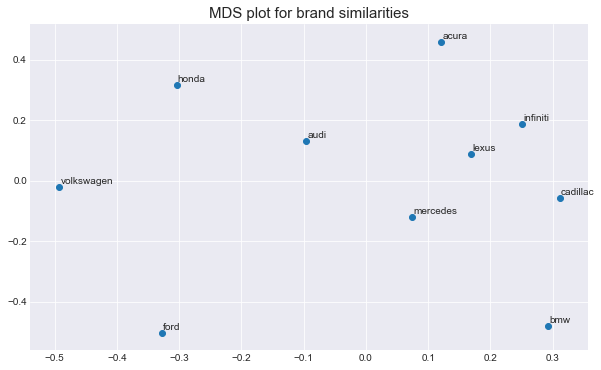

In [16]:
# plot the Multi dimensional scaling plot
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn-darkgrid')
plt.figure(figsize = (10,6))

model = MDS(n_components = 2,
            dissimilarity = 'precomputed', 
            random_state = 6,
            n_init = 500,
           max_iter = 5000)

out = model.fit_transform(dissimilarity_matrix)
plt.scatter(out[:, 0], out[:, 1])

for i in range(len(dissimilarity_matrix)):
    plt.text(out[i, 0] + 0.002, out[i, 1] + 0.01, dissimilarity_matrix.columns.values[i])

plt.title('MDS plot for brand similarities', fontsize = 15)

Our MDS plot confirms the suspicions that **Cadillac has successfully brought itself back from the dead.** Enthusiasts have begun saying it has surpassed the German luxury brand BMW. To quote a recent verge article comparing the ATS-V, Cadillac’s prime performance model, with the BMW M3, “The idea that a Cadillac could ever compete with a M3 would once have been heresy. But the current generation M3 has lost its way.” This trend can be seen on the plot, where **Cadillac has successfully rejoined the cluster ranks of true luxury with strong associations with Lexus, Infiniti and Mercedes.**

### When people talk about a brand, what feature do they most talk about?

There are various attributes of a car that people care about - styling, comfort, safety, etc. but more often than not we won't explicitly mention these attributes. For this reason, we create feature buckets and map terms/phrases that map to these features.

Words that talk about 
1. **Performance** - performance, awd, fwd, rwd, power, turbocharge, horsepower, hp, speed, acceleration, turbo, mph, 5-speed, 7-speed, engine, v6, v8, 4-speed, accelerator, manual, automatic, engines, cvt, sport, cylinder, cylinders, cyl, v-6, v-8, responsive and throttle.
2. **Fuel efficiency** - efficiency, mileage, mpg, gas, efficient, fuel, economy.
3. **Comfort** - luxury, room, tall, interior, interiors, luxurious, seat, seats, cargo, leather.
4. **Console** - console, entertainment, infotainment, music, cd, bluetooth, mp3, cds, stereo, player, dashboard, dash, audio, radio
5. **Safety**: safety, safe, airbags, airbag, tires, tire, radial, goodyear, bridgestone.
6. **Styling**: sunroof, color, paint, alloys, wheel, wheels, chrome, rims, headlight, headlights.

In [21]:
# read in the file with attribute and attribute mapping
attribute_mapping = pd.read_excel('Attributes.xlsx')

# convert to lower case and strip whitespace
attribute_mapping['Attribute'] = attribute_mapping['Attribute'].map(lambda x: x.rstrip().lower())
attribute_mapping['Mapping'] = attribute_mapping['Mapping'].map(lambda x: x.rstrip().lower())

#remove duplicate rows.
attribute_mapping = attribute_mapping.drop_duplicates().reset_index(drop = True)

In [ ]:
# replace attributes with their mappings
def replace_attribute_by_mapping(s):
    '''Given a string, this replaces the attributes mentioned in it by their mappings'''
    global attribute_mapping
    for i in range(len(attribute_mapping)):
        s = re.sub(r"\b%s\b" %attribute_mapping.loc[i, 'Attribute'], attribute_mapping.loc[i, 'Mapping'], s)
    return s

# replace all attributes by their mapping
df2['Message'] = df2['Message'].map(replace_attribute_by_mapping)

In [ ]:
# write this out to csv for future use
df2.to_csv('Messages_Model_Attribute_replaced.csv', index = False)

### Directly read the file with attributes replaced

In [17]:
df2 = pd.read_csv('Messages_Model_Attribute_replaced.csv')
df2.head()

,Date,User_Id,Message
0,"September 7, 2018",dino001,if they keep it around in next four-five years...
1,"September 7, 2018",circlew,the lease rate is the factor that stops me col...
2,"September 8, 2018",qbrozen,"yes, the completely noncomparable bmw would be..."
3,"September 9, 2018",FlightNurse2,why not a hyundai hyundai with a performance?
4,"September 9, 2018",FlightNurse2,are you talking about hyundai dealers or hyund...


### Association between brands and attributes

Now that we have replaced phrases with automobile features, its time to convert the messages into bag-of-words representation. We would then calculate lift between each brand and each of the features.

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer()

# these are counts of all words in the messages
X = np.array(df2.loc[:, 'Message'])
X_counts = count_vectorizer.fit_transform(X)

# column names for the counts
X_counts_matrix = np.where(X_counts.todense() > 0 , 1, 0)
column_names = [x for (x,y) in sorted(count_vectorizer.vocabulary_.items(), key = lambda x:x[1])]

count_df = pd.DataFrame(X_counts_matrix, columns = column_names)

We only need columns from this dataframe that have brands in them or attribute mappings. Let's do that next

In [22]:
# get a unique list of mapping names
mapping_names = attribute_mapping['Mapping'].unique().tolist()

# add the top 5 brands to make a complete list of brands + mappings
brands_consider_names = brands_consider[:5].index.tolist()
brand_mapping = brands_consider_names + mapping_names

In [23]:
# subset the dataframe on only brand_mapping
column_with_brand_mapping = count_df.columns.map(lambda x: x in brand_mapping)
brand_occurence = count_df.loc[:, column_with_brand_mapping]

brand_occurence.head()

,acura,audi,bmw,comfort,console,efficiency,honda,maintenance,mercedes,performance,safety,styling
0,0,0,1,0,0,1,0,0,0,1,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0


In [24]:
# get the combinations for which we have to calculate the lift
combinations = [(w,i) for w in brands_consider_names for i in mapping_names]

# calculate lift between the different brands and mappings
lift_brand_mapping = calc_lift(brand_occurence, combinations)
lift_brand_mapping.rename(columns = {'Brand1': "Brand",
                                    'Brand2': 'Attribute'}, inplace = True)

# sort lift by most to least
lift_brand_mapping = lift_brand_mapping.sort_values(['Attribute', 'Lift'], ascending = [True, False]).reset_index(drop = True)
lift_brand_mapping

,Brand,Attribute,Lift
0,mercedes,comfort,1.995757
1,honda,comfort,1.956721
2,acura,comfort,1.885359
3,audi,comfort,1.749578
4,bmw,comfort,1.497781
5,audi,console,1.828131
6,acura,console,1.692976
7,honda,console,1.640236
8,mercedes,console,1.594689
9,bmw,console,1.198281


### Insights

1. Based on our lift calculations, BMW is far from being the "ultimate driving machine" on Edmunds. BMW and the different car attributes have comparitively low lift values to the other top brands. This implies that when people are talking about different desirable car features, BMW does not come to mind. <br> <br>
2. Other than BMW, all of the other brands have high lift with the desirable car attributes. Each has a high lift exclusively in its own area, except for Audi and Acura. For the different product managers: Honda can continue working with its efficiency and safety features, Mercedes can continue working with its comfort features, and Audi and Acura can continue using their respective styling features. **BMW and Mercedes both have extremely low lift values for several features. The product managers for these brands need to place greater emphasis on these feature areas.** <br> <br>

3. Honda's advertising manager is working with a product with several marketable strengths, such as efficiency, safety, and comfort. **If the manager could do more to get people to associate performance with Honda, then Honda would have the strongest reputation that it possibly could among Edmunds forum users.** Mercedes needs to market more of its features other than comfort, as it is the only feature Mercedes is the prime example for (in the top 5 brands). Audi and Acura both have styling as a part of their brand reputations. Advertising managers for these companies need not worry about the other since our MDS plot shows that Audi and Acura are dissimilar enough to imply that their markets have only small intersections. Lastly, BMW needs to do a better job at marketing its product overall. 

## What is the most aspirational brand?

### Approach -

**Step 1:** *Get a list of positive words and keep only those that are in the corpus*

In [53]:
# get all positive words
positive_words = []
file = open('positive_words.txt', 'r')
line = file.readline()

while len(line) != 0:
    positive_words.append(line.rstrip().lstrip())
    line = file.readline()

file.close()

In [54]:
# check which positive words from the list are there in my messages
corpus = " ".join(df2.loc[:, 'Message'])
tokens = nltk.word_tokenize(corpus)

keep_positive = []
for i in positive_words:
    if i in tokens:
        keep_positive.append(i)

**Step 2:** *Replace all positive words by 'awesome'*

In [55]:
# Find all positive words and replace by 'awesome'.
def replace_positive(s):
    '''Given a string, this replaces the positive words in it by awesome and negative by awful'''
    global keep_positive    
    for i in range(len(keep_positive)):
        s = re.sub(r"\b%s\b" %keep_positive[i], 'awesome', s)
    return s

# replace all attributes by their mapping
df2['Message'] = df2['Message'].map(replace_positive)

**Step 3:** *Prepare data to calculate the lift between brands and the word 'awesome'*

In [56]:
# add the top 5 brands to make a complete list of brands + mappings
brands_consider_names = brands_consider[:10].index.tolist()
words_consider = ['awesome']
brand_words = brands_consider_names + words_consider

In [61]:
count_vectorizer = CountVectorizer()

# these are counts of all words in the messages
X = np.array(df2.loc[:, 'Message'])
X_counts = count_vectorizer.fit_transform(X)

# column names for the counts
X_counts_matrix = np.where(X_counts.todense() > 0 , 1, 0)
column_names = [x for (x,y) in sorted(count_vectorizer.vocabulary_.items(), key = lambda x:x[1])]

count_df = pd.DataFrame(X_counts_matrix, columns = column_names)

# subset the dataframe on only brand_mapping
column_with_brand_words = count_df.columns.map(lambda x: x in brand_words)
brand_occurence = count_df.loc[:, column_with_brand_words]

brand_occurence.head()

,acura,audi,awesome,bmw,cadillac,ford,honda,infiniti,lexus,mercedes,volkswagen
0,0,0,1,1,0,0,0,0,0,0,0
1,0,0,1,1,0,0,0,0,0,0,0
2,0,0,1,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0
4,1,0,1,0,0,0,0,1,1,0,0


**Step 4:** *Brand with the most lift is the most aspirational*

In [60]:
# get the combinations for which we have to calculate the lift
combinations = [(w,i) for w in brands_consider_names for i in words_consider]

# calculate lift between the different brands and mappings
lift_brand_words = calc_lift(brand_occurence, combinations)
lift_brand_words.rename(columns = {'Brand1': "Brand",
                                    'Brand2': 'Sentiment'}, inplace = True)

# sort lift by most to least
lift_brand_words = lift_brand_words.sort_values(['Brand', 'Lift'], ascending = [True, False]).reset_index(drop = True)

lift_brand_words.sort_values('Lift', ascending = False)

,Brand,Sentiment,Lift
5,honda,awesome,1.120338
9,volkswagen,awesome,1.100386
4,ford,awesome,1.100242
1,audi,awesome,1.086003
7,lexus,awesome,1.084149
0,acura,awesome,1.080390
8,mercedes,awesome,1.074965
3,cadillac,awesome,1.073318
2,bmw,awesome,1.071847
6,infiniti,awesome,1.060617


Based on our data, the most aspirational brand is Honda. This means that most people are talking about wanting a Honda. Honda can continue to market their cars and try to widen the gap between the other brands. We can credit Honda's success to the amount of dissimilarity that it exhibits in the MDS plot, as no other brands are close to Honda. Furthermore, Honda showed the most association with multiple attributes in Task C. This means that the brand is making itself differentiable (in a positive way) with its product and the different features avaiable. The business should continue to market Honda in this light.